Utility notebook to skim candidates

# Import

In [1]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import itertools
import json
from IPython.display import IFrame, Image, display
from multiprocessing import Pool

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import interp1d
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from cebefo_style import Set_2D_colz_graphics
from gridVarQ2Plot import col_dic, plot_gridVarQ2
from progressBar import ProgressBar
from categoriesDef import categories
from B02DstMu_selection import candidate_selection, trigger_selection, candidateSelection_stringList, candidateSelection_nameList

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = "     Simulation Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Create histograms file

In [3]:
MCloc = '../data/cmsMC_private/BPH_Tag-'
file_loc = {
# 'mu_PU0' : MCloc+'B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU0_10-2-3/ntuples_B2DstMu/out_CAND_*.root',    
'mu_PU20': MCloc+'B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'mu_PU35': MCloc+'B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU35_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'mu_HQETPU0': MCloc+'B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_HQET2_central_PU0_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'tau_PU0': MCloc+'B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU0_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'tau'   : MCloc+'B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'Hc'    : MCloc+'B0_DmstHc-pD0bar-kp-Hc2mu_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'Dstst' : MCloc+'Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'data' : '../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200210_CAND.root'
}

In [4]:
# RDloc = '../data/cmsRD/ParkingBPH*/'
# file_loc = {
# 'dataB2DstMu': RDloc+'*_RDntuplizer_B2DstMu_200304_CAND.root'
# }

In [5]:
def makeSelection(inputs):
    tag, filepath, leafs_names, cat, idxInt, skipCut, serial = inputs
    N_accepted_cand = []
    N_accepted_tot = 0
    
    tree = rt.TChain('outA/Tevts')
    lastIdxDisc = -1
    for fn in glob(filepath):
        tree.Add(fn)
        if tree.GetEntries() + lastIdxDisc < idxInt[0]:
            lastIdxDisc += tree.GetEntries()
            tree = rt.TChain('outA/Tevts')
        elif tree.GetEntries() + lastIdxDisc > idxInt[1]:
            break
    
    nDiscEvts = lastIdxDisc + 1
            
        
    if serial:
        pb = ProgressBar(maxEntry=idxInt[1]+1)
    else:
        perc = int((idxInt[1]-idxInt[0])*0.3)
    
    output = np.zeros((int(1.5*(idxInt[1]-idxInt[0]+1)), len(leafs_names)))
    for i_ev, ev in enumerate(tree):
        i_ev += nDiscEvts
        if i_ev < idxInt[0]:
            continue
        if i_ev > idxInt[1]:
            break
            
        if serial:
            pb.show(i_ev-idxInt[0])
        elif (i_ev-idxInt[0]) % perc == 0:
            print tag, ': {:.0f}%'.format(100*(i_ev+1-idxInt[0])/(idxInt[1]-idxInt[0]))
        N_acc = 0

        for j in range(ev.pval_piK.size()):
            idxTrg = int(ev.mu_trgMu_idx[j])
            if not skipCut == 'all':
                if not candidate_selection(j, ev, skipCut):
                    continue

                if not trigger_selection(idxTrg, ev, cat): 
                    continue

            N_acc += 1
            
            idx_st = 0
            for jjj in range(j):
                idx_st += int(ev.nTksAdd[jjj])

            N_lowMassAddTks = 0
            idx_stop = int(idx_st + ev.nTksAdd[j])
            for jj in range(idx_st, idx_stop):
                if ev.tksAdd_massVis[jj] < 5.28 and ev.tksAdd_cos_PV[jj]>0.95:
                    N_lowMassAddTks += 1
            

            aux = (ev.q2_D0pismu[j], ev.Est_mu_D0pismu[j], ev.M2_miss_D0pismu[j],
                   ev.trgMu_pt[idxTrg], ev.trgMu_eta[idxTrg], ev.trgMu_phi[idxTrg], ev.trgMu_sigdxy[idxTrg],
                   ev.B_D0pismu_pt[j], ev.B_D0pismu_eta[j], ev.B_D0pismu_phi[j],
                   ev.Dst_refitD0pismu_pt[j], ev.Dst_refitD0pismu_eta[j], ev.Dst_refitD0pismu_phi[j],
                   ev.D0_refitD0pismu_pt[j], ev.D0_refitD0pismu_eta[j], ev.D0_refitD0pismu_phi[j],
                   ev.pi_pt[j], ev.pi_eta[j], ev.pi_phi[j], ev.sigdxy_pi_PV[j],
                   ev.K_pt[j], ev.K_eta[j], ev.K_phi[j], ev.sigdxy_K_PV[j],
                   ev.pval_piK[j], ev.sigdxy_vtxD0_PV[j],
                   ev.pis_pt[j], ev.pis_eta[j], ev.pis_phi[j], ev.sigdxy_pis_PV[j],
                   ev.pval_D0pis[j],
                   ev.mass_piK[j], ev.mass_D0pis[j], ev.mass_D0pismu[j],
                   ev.pval_D0pismu[j], ev.cos_D0pismu_PV[j], ev.cosT_D0pismu_PV[j],
                   N_lowMassAddTks,
                   trigger_selection(idxTrg, ev, categories['low']),
                   trigger_selection(idxTrg, ev, categories['mid']),
                   trigger_selection(idxTrg, ev, categories['high']),
                   ev.N_vertexes
                  )
            if not 'data' in n:
                aux += (ev.MC_q2, ev.MC_Est_mu, ev.MC_M2_miss,
                        ev.MC_B_pt, ev.MC_B_eta, ev.MC_B_phi,
                        ev.MC_Dst_pt, ev.MC_Dst_eta, ev.MC_Dst_phi,
                        ev.MC_mu_pt, ev.MC_mu_eta, ev.MC_mu_phi, ev.MC_mu_IP,
                        ev.MC_idxCand == j
                       )
            if 'mu' in n or 'tau' in n:
                aux += (ev.wh_CLNCentral,
                        ev.wh_CLNR0Down, ev.wh_CLNR0Up,
                        ev.wh_CLNR1Down, ev.wh_CLNR1Up,
                        ev.wh_CLNR2Down, ev.wh_CLNR2Up,
                        ev.wh_CLNRhoSqDown, ev.wh_CLNRhoSqUp,
                       )
        
            output[N_accepted_tot] = aux
            N_accepted_tot += 1

        if N_acc > 0:
            N_accepted_cand.append(N_acc)

    output = output[:N_accepted_tot]
    if not serial:
        print tag, ': done'
    return [output, N_accepted_cand]

In [6]:
def create_dSet(n, filepath, cat, skipCut=None, maxEntries=1e15):  
    if skipCut=='all' and cat is None:
        catName = 'All'
    else:
        catName = cat.name
    print n, catName
    if 'data' in n:
        loc = '../data/cmsRD/skimmed/B2DstMu_' + filepath[-16:-10]
        fskimmed_name = loc + '_' + catName 
        if not skipCut is None:
            fskimmed_name += '_skip'+str(skipCut)
        fskimmed_name += '.root'
    else:
        d = os.path.dirname(filepath) + '/skimmed/'
        if not os.path.isdir(d):
            os.makedirs(d)
        fskimmed_name = d + catName 
        if not skipCut is None:
            fskimmed_name += '_skip'+str(skipCut)
        fskimmed_name += '.root'
    logfile = fskimmed_name.replace('.root', '.log')
    if os.path.isfile(fskimmed_name) and not n in recreate:
        print 'Already present'
    else:
        tree = rt.TChain('outA/Tevts')
        for fn in glob(filepath):
            tree.Add(fn)
        N_cand_in = min(maxEntries, tree.GetEntries())
        print n, ': Total number of candidate events =', N_cand_in
            
        leafs_names = ['q2', 'Est_mu', 'M2_miss',
                       'mu_pt', 'mu_eta', 'mu_phi', 'mu_sigdxy',
                       'B_pt', 'B_eta', 'B_phi',
                       'Dst_pt', 'Dst_eta', 'Dst_phi',
                       'D0_pt', 'D0_eta', 'D0_phi',
                       'pi_pt', 'pi_eta', 'pi_phi', 'pi_IP',
                       'K_pt', 'K_eta', 'K_phi', 'K_IP',
                       'pval_piK', 'sigdxy_vtxD0_PV',
                       'pis_pt', 'pis_eta', 'pis_phi', 'pis_IP',
                       'pval_D0pis',
                       'mass_piK', 'mass_D0pis', 'mass_D0pismu',
                       'pval_D0pismu', 'cos_D0pismu_PV', 'cosT_D0pismu_PV',
                       'N_lowMassAddTks',
                       'cat_low', 'cat_mid', 'cat_high',
                       'N_vtx'
                      ]
        if not 'data' in n:
            leafs_names += ['MC_q2', 'MC_Est_mu', 'MC_M2_miss',
                            'MC_B_pt', 'MC_B_eta', 'MC_B_phi',
                            'MC_Dst_pt', 'MC_Dst_eta', 'MC_Dst_phi',
                            'MC_mu_pt', 'MC_mu_eta', 'MC_mu_phi', 'MC_mu_IP',
                            'MC_idxMatch'
                           ]
        if 'mu' in n or 'tau' in n:
            leafs_names += ['wh_CLNCentral', 
                            'wh_CLNR0Down', 'wh_CLNR0Up', 
                            'wh_CLNR1Down', 'wh_CLNR1Up', 
                            'wh_CLNR2Down', 'wh_CLNR2Up', 
                            'wh_CLNRhoSqDown', 'wh_CLNRhoSqUp']
            
        if N_cand_in < 40000:
            output, N_accepted_cand = makeSelection(['', filepath, leafs_names, cat, 
                                                     [0, N_cand_in-1], skipCut, True])
        else:
            pdiv = list(np.arange(0, N_cand_in, 20000))
            if not pdiv[-1] == N_cand_in: 
                pdiv.append(N_cand_in)
            print 'Will be divided into ' + str(len(pdiv)-1) + ' jobs'
            inputs = []
            for i in range(1, len(pdiv)):
                corr = 0
                if i == 1:
                    corr = -1
                inputs.append([str(i), filepath, leafs_names, cat, [pdiv[i-1]+1+corr, pdiv[i]], skipCut, False])
            print ' '
            
            start = time.time()
            p = Pool(min(25,len(inputs)))
            outputs = p.map(makeSelection, inputs)
            output = np.concatenate(tuple([o[0] for o in outputs]))
            N_accepted_cand = []
            for o in outputs: N_accepted_cand += o[1]
            print 'Total time: {:.1f} min'.format((time.time()-start)/60.)
                
        
        dset = pd.DataFrame(output, columns=leafs_names)
        if not os.path.isdir(os.path.dirname(fskimmed_name)):
            os.makedirs(os.path.dirname(fskimmed_name))
        rtnp.array2root(dset.to_records(), fskimmed_name, treename='Tevts', mode='RECREATE')
        
        with open(logfile, 'w') as f:
            ln = 'Number of candidates per events\n{'
            ln += ', '.join(['{}:{}'.format(i, N_accepted_cand.count(i)) for i in range(1, np.max(N_accepted_cand)+1)])
            ln += '}\n'
            f.write(ln)
            f.write('N_analyzed: '+str(N_cand_in)+'\n')
            f.write('N_accepted: '+str(dset.shape[0])+'\n')
            e = getEff(dset.shape[0], N_cand_in)
            f.write('Eff: {:.3f} +/- {:.3f} %'.format(1e2*e[0], 1e2*e[1])+'\n')
         
    os.system('echo '+logfile+';cat '+logfile + ';echo ')

In [7]:
from categoriesDef import categories

recreate = []#file_loc.keys()

for n, fp in file_loc.iteritems():
    create_dSet(n, fp, None, 'all')

# for cn in ['low', 'mid', 'high']:
#     for n, fp in file_loc.iteritems():
#         create_dSet(n, fp, categories[cn])

# for n, fp in file_loc.iteritems():
#         create_dSet(n, fp, categories['mid'])

# for sk in range(1,22):
#     for cn in ['low']: #, 'mid', 'high']:
#         for n, fp in file_loc.iteritems():
#             create_dSet(n, fp, categories[cn], sk)

Dstst All
Dstst : Total number of candidate events = 190142
Will be divided into 10 jobs
 
1 : 0%
10 : 0%
8 : 0%
2 : 0%
7 : 0%
9 : 0%
5 : 0%
3 : 0%
4 : 0%
10 : 30%
8 : 30%
3 : 30%
4 : 30%
7 : 30%
9 : 30%
10 : 60%
5 : 30%
1 : 30%
8 : 59%
10 : 90%
10 : done
3 : 59%
4 : 59%
9 : 59%
7 : 59%
8 : 89%
5 : 59%
8 : done
4 : 89%
3 : 89%
4 : done
7 : 89%
3 : done
7 : done
5 : 89%
6 : 0%
5 : done
9 : 89%
9 : done
6 : 30%
2 : 30%
6 : 59%
6 : 89%
1 : 60%
6 : done
2 : 59%
1 : 90%
1 : done
2 : 89%
2 : done
Total time: 3.2 min


../lib/analysis_utilities.py:98: RuntimeWarning: invalid value encountered in sqrt
  de = np.sqrt(e*(1-e)/N)


tau All
Already present
mu_PU20 All
Already present
Hc All
Hc : Total number of candidate events = 78806
Will be divided into 4 jobs
 
1 : 0%
2 : 0%
3 : 0%
4 : 0%
2 : 30%
4 : 30%
3 : 30%
1 : 30%
2 : 59%
1 : 60%
3 : 59%
4 : 60%
2 : 89%
1 : 90%
3 : 89%
4 : 89%
2 : done
1 : done
4 : done
3 : done
Total time: 0.8 min
../data/cmsMC_private/BPH_Tag-Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/skimmed/All_skipall.log
Number of candidates per events
{1:187045, 2:3090, 3:3, 4:4}
N_analyzed: 190142
N_accepted: 193250
Eff: 101.635 +/- nan %

../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/skimmed/All_skipall.log
Number of candidates per events
{1:159901, 2:1020, 3:4, 4:4}
N_analyzed: 160929
N_accepted: 161969
Eff: 100.646 +/- nan %

../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu

# Analyze selection efficiencies

In [8]:
def getTree(n, filepath, cat, skipCut=None, maxEntries=1e15):  
    if skipCut=='all' and cat is None:
        catName = 'All'
    else:
        catName = cat.name
    print n, catName, skipCut
    if 'data' in n:
        pass
    else:
        d = os.path.dirname(filepath) + '/skimmed/'
        fskimmed_name = d + catName 
        if not skipCut is None:
            fskimmed_name += '_skip'+str(skipCut)
        fskimmed_name += '.root'
    if os.path.isfile(fskimmed_name):
        t = rt.TChain('Tevts')
        t.Add(fskimmed_name)
        return t
    else: return None

## Get efficiency per cut

In [9]:
T = {}
for n, fp in file_loc.iteritems():
    aux = getTree(n, fp, None, 'all', maxEntries=1e9)
    if not aux is None:
        T[n] = aux
    else:
        raise

Dstst All all
tau All all
mu_PU20 All all
Hc All all


Dstst
[####################]  100% - Tot. time: 0.5 s
Hc
[####################]  100% - Tot. time: 0.2 s
mu_PU20
[####################]  100% - Tot. time: 3.6 s
tau
[####################]  100% - Tot. time: 0.4 s


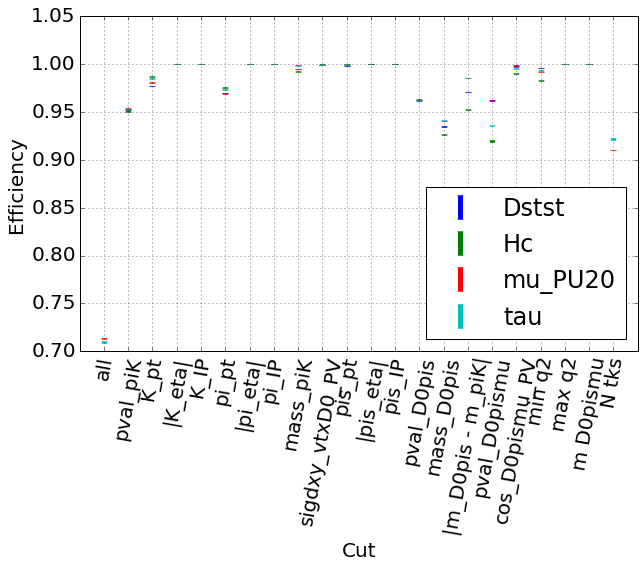

In [10]:
allCuts = ' && '.join(candidateSelection_stringList)
eff = {}
for n, t in T.iteritems():
    print n
    eff[n] = np.zeros((len(candidateSelection_stringList)+1,2))
    Ntot = float(t.GetEntries())
    Nsel = t.GetEntries(allCuts)
    eff[n][0] = getEff(Nsel, Ntot)
    pb = ProgressBar(maxEntry=len(candidateSelection_stringList))
    for ic, c in enumerate(candidateSelection_stringList):
        pb.show(ic)
        eff[n][ic+1] = getEff(t.GetEntries(c), Ntot)

for n in T.keys():
    y = np.array(eff[n])
    x = np.arange(y.shape[0])
    plt.errorbar(x, y[:, 0], y[:,1], lw=0, elinewidth=5, label=n)

plt.rcParams.update({'font.size': 20})
plt.xlabel('Cut')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.xticks(range(len(candidateSelection_nameList)+1), ['all']+candidateSelection_nameList, rotation=80)
plt.ylim(0.7,1.05)
plt.xlim(-1, len(candidateSelection_nameList)+1)
plt.grid()
plt.gcf().set_size_inches(10, 6)

Dstst
Dstst 9.48 +/- 0.07 %
Dstst 6.18 +/- 0.05 %
Dstst 4.58 +/- 0.05 %
Hc
Hc 18.29 +/- 0.14 %
Hc 10.75 +/- 0.11 %
Hc 8.59 +/- 0.10 %
mu_PU20
mu_PU20 24.31 +/- 0.04 %
mu_PU20 18.57 +/- 0.03 %
mu_PU20 20.04 +/- 0.03 %
tau
tau 29.19 +/- 0.11 %
tau 18.00 +/- 0.10 %
tau 14.04 +/- 0.09 %


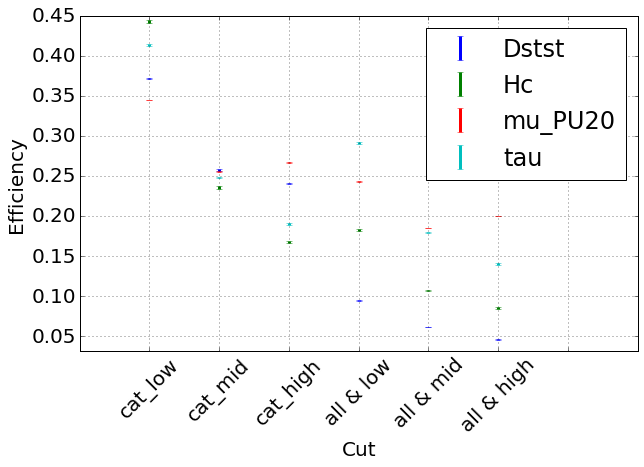

In [11]:
allCuts = ' && '.join(candidateSelection_stringList)
cat = ['cat_low', 'cat_mid', 'cat_high']
eff = {}
for n, t in T.iteritems():
    print n
    eff[n] = np.zeros((2*len(cat), 2))
    Ntot = float(t.GetEntries())
    Nsel = t.GetEntries(allCuts)
    eff[n][0] = getEff(Nsel, Ntot)
    for ic, c in enumerate(cat):
        eff[n][ic] = getEff(t.GetEntries(c), Ntot)
    for ic, c in enumerate(cat):
        eff[n][ic+len(cat)] = getEff(t.GetEntries(c + ' && ' + allCuts), Ntot)
        print n, '{:.2f} +/- {:.2f} %'.format(*(100*eff[n][ic+len(cat)]))

for n in T.keys():
    y = np.array(eff[n])
    x = np.arange(y.shape[0])
    plt.errorbar(x, y[:, 0], y[:,1], lw=0, elinewidth=3, label=n)

plt.rcParams.update({'font.size': 20})
plt.xlabel('Cut')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.xticks(range(2*len(cat)+1), cat+['all & '+c.replace('cat_', '') for c in cat], rotation=45)
plt.ylim(0.7*np.min([np.min(e[:,0]) for e in eff.values()]), plt.ylim()[1])
plt.xlim(-1,plt.xlim()[1]+1)
# plt.yscale('log')
plt.grid()
plt.gcf().set_size_inches(10, 6)